**The purpose of this notebook is to create a cleaned and preprocessed dataset that contains only high-quality records, serving as a powerful input to a collaborative filtering recommender system. Naturally, the ratings and textual reviews are critical features to take into consideration.**

### 1. Import the requiered libraries

In [1]:
import pandas as pd
import numpy as np
import gzip
import simplejson as json
import re
from nltk.tokenize import RegexpTokenizer

### 2. Read the data and explore it

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF("db amazon original.json.gz")

In [3]:
df.head(3)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"11 9, 2012",A2M1CU2IRZG0K9,0005089549,{'Format:': ' VHS Tape'},Terri,So sorry I didn't purchase this years ago when...,Amazing!,1352419200,NaN,NaN
1,5.0,True,"12 30, 2011",AFTUJYISOFHY6,0005089549,{'Format:': ' VHS Tape'},Melissa D. Abercrombie,Believe me when I tell you that you will recei...,Great Gospel VHS of the Cathedrals!,1325203200,NaN,NaN
2,5.0,True,"04 21, 2005",A3JVF9Y53BEOGC,000503860X,{'Format:': ' DVD'},Anthony Thompson,"I have seen X live many times, both in the ear...",A great document of a great band,1114041600,11,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3410019 entries, 0 to 3410018
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   overall         float64
 1   verified        bool   
 2   reviewTime      object 
 3   reviewerID      object 
 4   asin            object 
 5   style           object 
 6   reviewerName    object 
 7   reviewText      object 
 8   summary         object 
 9   unixReviewTime  int64  
 10  vote            object 
 11  image           object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 315.4+ MB


**The reviewerID column has practically the same purpose as reviewerName, and therefore, we will keep only one of these two columns.**

**The summary column is just a short version of the original textual review. Based on the purpose of this project, having the complete review will serve as a better input for the recommender, and therefore, we will skip the summary column.**

**Because we possess the reviewTime column, the unixReviewTime is not needed, and in consequence, we will also delete this column.**

In [5]:
# let's find out how many blank cells does image column have.
x = df.image.isnull().sum()
x

3403048

In [6]:
round(x/len(df), 3)

0.998

**There are only 6,971 images. This is a 0.2% of all the data records. Practically, the 99.8% of this column's cells are empty. Besides, we do not need images for the purpose of this project, and therefore, we will also delete this column.**

In [7]:
# let's find out how many blank cells does vote column have.
y = df.vote.isnull().sum()
y

2768010

In [8]:
round(y/len(df), 3)

0.812

**18.8% of all the reviews have 1 or more helpful votes. In other words, the 81.2% of the reviews in this dataset have 0 helpful votes. Let's explore this feature a little bit more to determine what to do.**

In [9]:
print('The number of unique values of the vote column is: ', len(df['vote'].unique()))
print('There are a total of {} empty cells in this column.'.format(df.vote.isnull().sum()))
print('There are a total of {} cells with values in vote.'.format(df.vote.notnull().sum()))
print('The unique values are:')
print(df['vote'].value_counts())

The number of unique values of the vote column is:  642
There are a total of 2768010 empty cells in this column.
There are a total of 642009 cells with values in vote.
The unique values are:
2        197779
3        110227
4         70334
5         48249
6         34344
          ...  
474           1
821           1
1,346         1
531           1
691           1
Name: vote, Length: 641, dtype: int64


#### 2.1. Modify reviewTime and convert it into year

In [10]:
df['reviewTime'] = pd.to_datetime(df['reviewTime'])

In [11]:
df['reviewTime'] = df['reviewTime'].dt.strftime('%Y')

In [12]:
df.head(3)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,2012,A2M1CU2IRZG0K9,0005089549,{'Format:': ' VHS Tape'},Terri,So sorry I didn't purchase this years ago when...,Amazing!,1352419200,NaN,NaN
1,5.0,True,2011,AFTUJYISOFHY6,0005089549,{'Format:': ' VHS Tape'},Melissa D. Abercrombie,Believe me when I tell you that you will recei...,Great Gospel VHS of the Cathedrals!,1325203200,NaN,NaN
2,5.0,True,2005,A3JVF9Y53BEOGC,000503860X,{'Format:': ' DVD'},Anthony Thompson,"I have seen X live many times, both in the ear...",A great document of a great band,1114041600,11,NaN


#### 2.2. Analyze the vote column

<AxesSubplot:xlabel='reviewTime'>

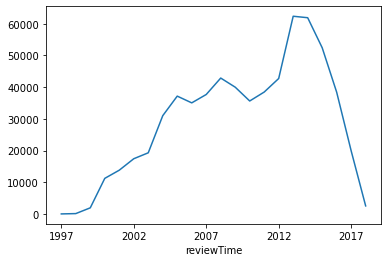

In [13]:
# how many helpful votes are per year with a line graph.
df.groupby("reviewTime").count().vote.plot(kind='line')

In [14]:
df.groupby("reviewTime").count().vote

reviewTime
1997        0
1998      102
1999     1923
2000    11219
2001    13801
2002    17417
2003    19290
2004    31000
2005    37178
2006    35048
2007    37691
2008    42880
2009    40000
2010    35641
2011    38464
2012    42736
2013    62388
2014    61924
2015    52453
2016    38416
2017    19907
2018     2531
Name: vote, dtype: int64

<AxesSubplot:xlabel='reviewTime'>

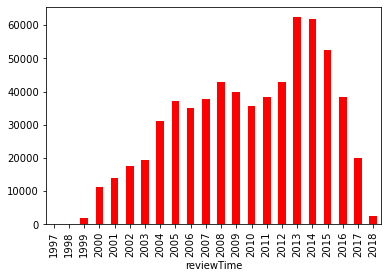

In [15]:
# how many helpful votes are per year with a bar graph.
df.groupby("reviewTime").count().vote.plot(kind='bar', color='r')

<AxesSubplot:xlabel='reviewTime'>

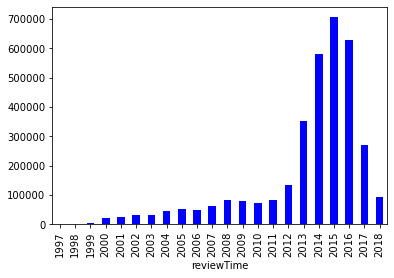

In [16]:
# let's see if this fits the behaviour of number of reviews per year.
df.groupby("reviewTime").count().reviewText.plot(kind='bar', color='b')

**Even though the number of reviews per year increases in 2013, 2014, and 2015, there is still a trend for the total number of helpful votes per year to decrease. Should we leave this column out of the analysis or not? Let's see one more thing.**

In [17]:
# let's find out how many unique values do some the verified column have.
df['verified'].value_counts()

True     2503105
False     906914
Name: verified, dtype: int64

**As you can see, there are 906,914 reviews that have not been verified yet. This is a 26.6% of the whole dataset. Instead of getting rid of all of these unverified reviews, we can try to "verify" them with the help of the help votes. We can create a rule, for example, if a review has not been verified yet, and it has 4 or more helpful votes, then it can be considered as verified. Let's use this rule!**

#### 2.3. Verifying reviews through the vote column

In [18]:
df.vote = df['vote'].str.replace(',', '').astype(float)

In [19]:
len(df[(df['vote'] > 3) & (df['verified'] == False)])

207159

**There are a total of 207,159 reviews that have 4 or more helpful votes and are not verified yet. Through this way, we can verify 207,159 reviews out of 906,914, keeping a 22.8% of these data.**

In [20]:
df[(df['vote'] > 3) & (df['verified'] == False)].head(3)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
26,3.0,False,2001,A17TPT3FWAE5T1,0005019281,{'Format:': ' VHS Tape'},Matthew Spady,If you already have (and love) the Alistair Si...,An interesting contrast to more traditional ve...,1008028800,31.0,NaN
27,4.0,False,2001,A3P98J5DZ00A75,0005019281,{'Format:': ' DVD'},Ken Roberts,Henry Winkler proves his acting ability in thi...,grey,1003449600,62.0,NaN
319,5.0,False,2006,AARUYE130LY8W,0005019281,{'Format:': ' DVD'},Paul D. Race,"If you want the classic version, go with the G...",Best Adaptation Ever,1166400000,5.0,NaN


In [21]:
df.loc[((df['vote'] > 3) & (df['verified'] == False)), 'verified'] = True

In [22]:
df[(df['vote'] > 3) & (df['verified'] == False)].head(3)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image


In [23]:
df['verified'].value_counts()

True     2710264
False     699755
Name: verified, dtype: int64

**We verified 207,159 reviews... and that is why the number of False in verified column decreases from 906,914 to 699,755. We are not longer going to use the vote column, and threfore we can skip it. We can also delete rows with False values in verified column.**

In [24]:
df = df[df['verified']==True]
print(len(df))

2710264


### 3. Filter dataset using only columns of interest

In [25]:
df = df[['overall', 'reviewTime', 'reviewerID','asin', 'style', 'reviewText']].copy()
print('Shape of df is:', df.shape)
df.head(3)

Shape of df is: (2710264, 6)


,overall,reviewTime,reviewerID,asin,style,reviewText
0,5.0,2012,A2M1CU2IRZG0K9,0005089549,{'Format:': ' VHS Tape'},So sorry I didn't purchase this years ago when...
1,5.0,2011,AFTUJYISOFHY6,0005089549,{'Format:': ' VHS Tape'},Believe me when I tell you that you will recei...
2,5.0,2005,A3JVF9Y53BEOGC,000503860X,{'Format:': ' DVD'},"I have seen X live many times, both in the ear..."


### 4. Filter dataset conserving rows from 2012 to 2018

<AxesSubplot:xlabel='reviewTime'>

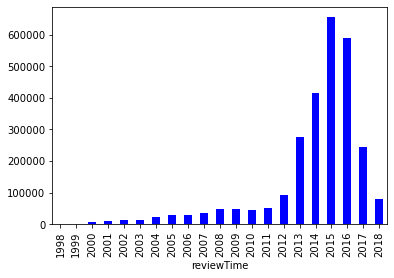

In [26]:
# let's see one more time the number of reviews per year.
df.groupby("reviewTime").count().reviewText.plot(kind='bar', color='b')

**We can appreciate that the number of reviews before 2012 is very little. Besides, we need to take into consideration that the interests of a person may change after many years, i.e., what a person liked in year 2000 may be different than what he would like in 2010. For these previous reasons, and to produce high-quality recommendations, we are just going to conserve recent information, i.e., reviews from 2012 to 2018.**

In [27]:
keepYears = ['2012', '2013', '2014','2015', '2016', '2017', '2018']

In [28]:
df = df[df.reviewTime.isin(keepYears)]
print('Shape of df is:', df.shape)

Shape of df is: (2354459, 6)


### 5. Filter dataset deleting rows with just an int as a review

**It is supposed that every record must have a numeric rating with a textual review. These rating-review pairs would be a good input for a recommender. If some reviews do not have any text and just include numeric data, then it is redundant or unnecesary. In consequence, we will delete the rows that have just a number as a review.**

In [29]:
df = df.reset_index(drop=True)

In [30]:
reviewsText = df.loc[:,'reviewText']

for i in range(len(reviewsText)):
    text = reviewsText[i]
    try:
        reviewsText.loc[i] = int(text)
    except Exception:
        pass

C:\Users\willi\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [31]:
df = df.drop('reviewText', 1)

In [32]:
df = df.join(reviewsText)

In [33]:
indexes_to_drop = []
for i in range(len(df)):
    if type(df.loc[i]['reviewText']) == int or type(df.loc[i]['reviewText']) == float:
        indexes_to_drop.append(i)
    else:
        pass 

In [34]:
print('Number of reviews with only a number in dataset: ', len(indexes_to_drop))
print(indexes_to_drop)

Number of reviews with only a number in dataset:  1753
[2272, 4200, 4890, 5237, 5334, 7190, 7451, 7559, 8096, 8594, 12034, 19799, 19975, 21207, 21805, 22125, 23675, 23723, 32327, 34430, 36152, 38112, 38902, 38952, 39520, 41586, 41665, 42610, 42714, 46035, 47442, 49973, 53523, 55280, 58208, 58732, 58905, 61726, 64090, 70455, 74286, 83061, 86910, 89045, 89163, 89718, 94793, 95776, 97008, 97342, 99414, 99777, 99831, 99883, 101174, 102574, 102739, 103765, 105889, 106514, 107975, 108493, 108542, 110586, 113244, 114317, 114697, 117683, 120125, 120582, 120841, 121331, 123708, 124408, 125406, 125418, 125906, 126203, 127461, 130102, 132217, 133073, 135882, 137611, 138398, 140265, 140972, 140991, 143674, 146938, 147361, 148026, 149155, 151478, 152219, 154167, 155077, 156520, 156722, 156895, 162950, 163920, 164249, 164853, 164984, 165248, 167219, 167742, 168689, 168821, 170644, 175539, 178548, 182364, 183629, 185279, 185848, 186634, 187594, 187648, 188201, 189295, 189526, 190198, 190446, 192080, 

In [35]:
df = df.drop(df.index[indexes_to_drop])
df.shape

(2352706, 6)

In [36]:
df.head(3)

,overall,reviewTime,reviewerID,asin,style,reviewText
0,5.0,2012,A2M1CU2IRZG0K9,0005089549,{'Format:': ' VHS Tape'},So sorry I didn't purchase this years ago when...
1,5.0,2016,A2CFV9UPFTTM10,0005419263,{'Format:': ' Audio CD'},The little ones love this
2,3.0,2014,A3139J3877Y61F,0005419263,{'Format:': ' Audio CD'},Good songs. The DVD is a little boring.


### 6. Filter dataset deleting rows with 1-2 chars as a review

**The idea of the review is to: (1) express an opinion that explains the why of your rating, or (2) detail a characteristic of the movie that called your attention and could serve as a decision guide for other users if to watch or not to watch the movie or TV show. A review with only 1 or 2 letters, symbols, or characters, probably does not express that much, so we can ignore these records.**

In [37]:
df = df.reset_index(drop=True)

In [38]:
indexes_to_drop = []
for i in range(len(df)):
    if len(df.loc[i]['reviewText']) <= 2:
        indexes_to_drop.append(i)
    else:
        pass 

In [39]:
print('Number of reviews with 2 or less characters in dataset: ', len(indexes_to_drop))
print(indexes_to_drop)

Number of reviews with 2 or less characters in dataset:  16473
[29, 106, 422, 618, 855, 861, 941, 1142, 1146, 1236, 1473, 1640, 1725, 1828, 1904, 2064, 2737, 2771, 2932, 2940, 2978, 3182, 3192, 3447, 3633, 3667, 3668, 3679, 3684, 3685, 3690, 3878, 4032, 4106, 4250, 4425, 5421, 5487, 5504, 5686, 5976, 6140, 6370, 6511, 7072, 7139, 7174, 7307, 7549, 7576, 7606, 7620, 7664, 7685, 7733, 7808, 8074, 8154, 8170, 8376, 8501, 8548, 8805, 8976, 9026, 9079, 9916, 10184, 10384, 10410, 10496, 10503, 10632, 10779, 10838, 10999, 11193, 11303, 11399, 11427, 11448, 11599, 11656, 13229, 13271, 13279, 13382, 13415, 13687, 13902, 13990, 14173, 14300, 14324, 14517, 14620, 15260, 15393, 15500, 15581, 15589, 15736, 16006, 16383, 16441, 16473, 16666, 16881, 16885, 17105, 17177, 17268, 17293, 17575, 17823, 17867, 17985, 18126, 18336, 18480, 18569, 18797, 18863, 18906, 18927, 19092, 19171, 19394, 19415, 19690, 19765, 19925, 19997, 20033, 20193, 20341, 20386, 20773, 20852, 20960, 21070, 21214, 21509, 22081, 222

**Take into consideration that probably here we are also deleting records with no data or blanks in the reviewText column.**

In [40]:
df = df.drop(df.index[indexes_to_drop])
df.shape

(2336233, 6)

### 7. Avoid the "#NAME?" error of reviews generated in csv

**It was found that reviews that contains "-" and "\n", once that they are save into a csv file, the reviews in the Excel are deleted and a "#NAME?" error appears. Accordingly, it is critical to eliminate white lines, i.e., "\n", and "-" in every review before they are saved into a CSV file. Examples of this error are:** 

*'- I enjoyed the subject matter and found it to be entertaining presentation of information\n-Obvious budget constraints hold it back\n- Presents info with very few facts backing it up\n- The Wizard Of OZ theme is over utilized'*

*'-cheesy as hell but still some episodes are watchable, ha\n-kinda like soft porn, a la Skinemax of yesteryear'*

In [41]:
df = df.reset_index(drop=True)

In [42]:
reviewsText = df.loc[:,'reviewText']
reviews = reviewsText.to_numpy()

In [43]:
# to replace every non-word character with a blank space.
raw1 = []

for comment in reviews:
    raw1.append(re.sub(r'[^\w]', ' ', str(comment)))

raw1[:3]

['So sorry I didn t purchase this years ago when it first came out    This is very good and entertaining   We absolutely loved it and anticipate seeing it repeatedly   We actually wore out the cassette years back  so we also purchased this same product on cd   Best purchase we made out of all   Would purchase on dvd if we could find one ',
 'The little ones love this',
 'Good songs  The DVD is a little boring ']

In [44]:
# to convert every "word" inside a review into a token.
raw2 = []
tokenizer = RegexpTokenizer(r'\w+')

for comment in raw1:
    raw2.append(tokenizer.tokenize(str(comment)))
    
raw2[:3]

[['So',
  'sorry',
  'I',
  'didn',
  't',
  'purchase',
  'this',
  'years',
  'ago',
  'when',
  'it',
  'first',
  'came',
  'out',
  'This',
  'is',
  'very',
  'good',
  'and',
  'entertaining',
  'We',
  'absolutely',
  'loved',
  'it',
  'and',
  'anticipate',
  'seeing',
  'it',
  'repeatedly',
  'We',
  'actually',
  'wore',
  'out',
  'the',
  'cassette',
  'years',
  'back',
  'so',
  'we',
  'also',
  'purchased',
  'this',
  'same',
  'product',
  'on',
  'cd',
  'Best',
  'purchase',
  'we',
  'made',
  'out',
  'of',
  'all',
  'Would',
  'purchase',
  'on',
  'dvd',
  'if',
  'we',
  'could',
  'find',
  'one'],
 ['The', 'little', 'ones', 'love', 'this'],
 ['Good', 'songs', 'The', 'DVD', 'is', 'a', 'little', 'boring']]

In [45]:
raw3 = []
for comment in raw2:
    words_to_keep = []
    for word in comment:
        if word != 'n':
            words_to_keep.append(word)
        else:
            pass
    raw3.append(words_to_keep)

raw3[:3]

[['So',
  'sorry',
  'I',
  'didn',
  't',
  'purchase',
  'this',
  'years',
  'ago',
  'when',
  'it',
  'first',
  'came',
  'out',
  'This',
  'is',
  'very',
  'good',
  'and',
  'entertaining',
  'We',
  'absolutely',
  'loved',
  'it',
  'and',
  'anticipate',
  'seeing',
  'it',
  'repeatedly',
  'We',
  'actually',
  'wore',
  'out',
  'the',
  'cassette',
  'years',
  'back',
  'so',
  'we',
  'also',
  'purchased',
  'this',
  'same',
  'product',
  'on',
  'cd',
  'Best',
  'purchase',
  'we',
  'made',
  'out',
  'of',
  'all',
  'Would',
  'purchase',
  'on',
  'dvd',
  'if',
  'we',
  'could',
  'find',
  'one'],
 ['The', 'little', 'ones', 'love', 'this'],
 ['Good', 'songs', 'The', 'DVD', 'is', 'a', 'little', 'boring']]

In [46]:
df_raw = pd.DataFrame({'reviewText_raw': raw3})
df_raw.head(3)

,reviewText_raw
0,"[So, sorry, I, didn, t, purchase, this, years,..."
1,"[The, little, ones, love, this]"
2,"[Good, songs, The, DVD, is, a, little, boring]"


In [47]:
df_raw['reviewText'] = [','.join(map(str, x)) for x in df_raw['reviewText_raw']]
df_raw.head(3)

,reviewText_raw,reviewText
0,"[So, sorry, I, didn, t, purchase, this, years,...","So,sorry,I,didn,t,purchase,this,years,ago,when..."
1,"[The, little, ones, love, this]","The,little,ones,love,this"
2,"[Good, songs, The, DVD, is, a, little, boring]","Good,songs,The,DVD,is,a,little,boring"


In [48]:
df_raw = df_raw.drop('reviewText_raw', 1)
df = df.drop('reviewText', 1)
df = df.join(df_raw)

In [49]:
df.shape

(2336233, 6)

### 8. Preprocess the text contained in the style column

In [50]:
df.head(3)

,overall,reviewTime,reviewerID,asin,style,reviewText
0,5.0,2012,A2M1CU2IRZG0K9,0005089549,{'Format:': ' VHS Tape'},"So,sorry,I,didn,t,purchase,this,years,ago,when..."
1,5.0,2016,A2CFV9UPFTTM10,0005419263,{'Format:': ' Audio CD'},"The,little,ones,love,this"
2,3.0,2014,A3139J3877Y61F,0005419263,{'Format:': ' Audio CD'},"Good,songs,The,DVD,is,a,little,boring"


In [51]:
print(type(df['style'][0]))
print(df['style'][0])

<class 'dict'>
{'Format:': ' VHS Tape'}


In [52]:
# convert the style column to string so we can analyze it.
df['style'] = df['style'].astype('str')

In [53]:
# absolute count of the unique values in the style column.
df['style'].value_counts()

{'Format:': ' DVD'}                                1005772
{'Format:': ' Amazon Video'}                        820475
{'Format:': ' Blu-ray'}                             260706
{'Format:': ' Prime Video'}                         148347
nan                                                  88135
{'Format:': ' VHS Tape'}                              9650
{'Format:': ' DVD-R'}                                 1068
{'Format:': ' Audio CD'}                               404
{'Format:': ' DVD-ROM'}                                370
{'Format:': ' HD DVD'}                                 370
{'Format:': ' Amazon Instant Video'}                   208
{'Format:': ' UMD for PSP'}                            163
{'Format:': ' Interactive DVD'}                         83
{'Format:': ' Electronics'}                             69
{'Format:': ' Hardcover'}                               49
{'Format:': ' Paperback'}                               46
{'Format:': ' DVD Audio'}                               

In [54]:
# percentage count of the unique values in the style column.
df['style'].value_counts(normalize=True)

{'Format:': ' DVD'}                                4.305101e-01
{'Format:': ' Amazon Video'}                       3.511957e-01
{'Format:': ' Blu-ray'}                            1.115925e-01
{'Format:': ' Prime Video'}                        6.349838e-02
nan                                                3.772526e-02
{'Format:': ' VHS Tape'}                           4.130581e-03
{'Format:': ' DVD-R'}                              4.571462e-04
{'Format:': ' Audio CD'}                           1.729280e-04
{'Format:': ' DVD-ROM'}                            1.583746e-04
{'Format:': ' HD DVD'}                             1.583746e-04
{'Format:': ' Amazon Instant Video'}               8.903222e-05
{'Format:': ' UMD for PSP'}                        6.977044e-05
{'Format:': ' Interactive DVD'}                    3.552728e-05
{'Format:': ' Electronics'}                        2.953473e-05
{'Format:': ' Hardcover'}                          2.097394e-05
{'Format:': ' Paperback'}               

In [55]:
len(df['style'].unique())

46

**There are 46 unique values in the style column. Almost all of them represents almost 0% of the total information. Just the first five unique values (DVD, amazon Video, Blu-ray, Prime Video, and VHS Tape) represents the 96.1% of the total records. Thus, it makes sense to ignore and delete the rest and the blank cells.**

In [56]:
df['style'] = df['style'].str.slice(start=14, stop=-2)

In [57]:
df['style'].value_counts()

DVD                                1005772
Amazon Video                        820475
Blu-ray                             260706
Prime Video                         148347
                                     88135
VHS Tape                              9650
DVD-R                                 1068
Audio CD                               404
DVD-ROM                                370
HD DVD                                 370
Amazon Instant Video                   208
UMD for PSP                            163
Interactive DVD                         83
Electronics                             69
Hardcover                               49
Paperback                               46
DVD Audio                               39
Laser Disc                              37
Toy                                     32
Kindle Edition                          30
MP3 Music                               26
CD-ROM                                  22
Staple Bound                            18
known      

In [58]:
keepStyle = ['DVD', 'Amazon Video', 'Blu-ray','Prime Video', 'VHS Tape']

In [59]:
df = df[df['style'].isin(keepStyle)]

In [60]:
df.shape

(2244950, 6)

In [61]:
df.head(3)

,overall,reviewTime,reviewerID,asin,style,reviewText
0,5.0,2012,A2M1CU2IRZG0K9,0005089549,VHS Tape,"So,sorry,I,didn,t,purchase,this,years,ago,when..."
3,4.0,2016,A2QWTVQ90KYZZP,0005092663,DVD,"REALLY,ENJOYED"
4,5.0,2016,AK1BZVQ7X9EJR,0005092663,DVD,"excellent,as,usual"


### 9. Filter dataset skipping rows with NaN values

In [62]:
# let's discover the number of empty cells in each of the columns.
df.replace('', np.nan, inplace=True)
df.replace('null', np.nan, inplace=True)
df.isnull().sum()

overall         0
reviewTime      0
reviewerID      0
asin            0
style           0
reviewText    250
dtype: int64

In [63]:
df = df[df.reviewText.notnull()]

In [64]:
df.shape

(2244700, 6)

In [65]:
# lets guarantee there are not null values or balnks.
df.isnull().sum()

overall       0
reviewTime    0
reviewerID    0
asin          0
style         0
reviewText    0
dtype: int64

### 10. Databases ready to be analyzed and eaten

**The cleaned and preprocessed dataset should have 2,244,700 records and 6 columns. To export this dataset into a csv file we just need to run the line of code below. Nonetheless, because it is too much data, we will also export a csv file that contains only 500,000 data points. These data records will be selected randomly.**

In [66]:
# export_csv = df.to_csv('db amazon mineros 1.csv', index = None, header=True)

In [67]:
df_small = df.sample(n = 500000)

In [68]:
export_csv = df_small.to_csv('db amazon mineros 2.csv', index = None, header=True)